In [1]:
%load_ext autoreload
%autoreload 2

import os, sys
import numpy
from collections import defaultdict, Counter
import datetime


In [2]:
print(os.getcwd())
sys.path.insert(0, str(os.path.dirname(os.path.realpath(os.getcwd()))))
print(sys.path)

/mnt/f/dev/git/miRExplore/python/nbs
['/mnt/f/dev/git/miRExplore/python', '/mnt/f/dev/git/miRExplore/python/nbs', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/usr/local/lib/python3.8/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.8/dist-packages/IPython/extensions', '/home/mjoppich/.ipython']


In [135]:
from textdb.PubmedDateDB import PubmedDateDB
from synonymes.mirnaID import miRNA, miRNAPART,miRNACOMPARISONLEVEL
from textdb.MiGenRelDB import MiGenRelDB

import requests, json
from synonymes.GeneOntology import GeneOntology
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from scipy.stats import hypergeom
from statsmodels.stats.multitest import multipletests

import math


In [85]:
diseaseObo = GeneOntology("/mnt/f/dev/data/pmid_jun2020/obodir/" + "/doid.obo")
cellObo = GeneOntology("/mnt/f/dev/data/pmid_jun2020/obodir/" + "/meta_cells.obo")
goObo = GeneOntology("/mnt/f/dev/data/pmid_jun2020/obodir/" + "/go.obo")

infodict2obo = {}
infodict2obo["cells"] = cellObo
infodict2obo["disease"] = diseaseObo
infodict2obo["go"] = goObo

0
10000
no parent 2382
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
no parent 43429
0
10000
20000
30000
40000
no parent 2106


In [100]:
context = {'cells': [{'termid': "META:44"}]}
#context = {}
requestDict = {"gene": [], "mirna": [], "sentences": "false"}

for x in context:
    requestDict[x] = context[x]

r = requests.post("http://localhost:65500/find_interactions", data=json.dumps(requestDict))
jsonResTcell = r.json()

In [101]:
context = {}
requestDict = {"gene": [], "mirna": [], "sentences": "false"}

for x in context:
    requestDict[x] = context[x]

r = requests.post("http://localhost:65500/find_interactions", data=json.dumps(requestDict))
jsonResAll = r.json()

In [97]:
def prepareJsonRes(jsonRes, termDimension="go"):
    all_mirnas = set()
    doc2mirnas = defaultdict(set)
    doc2terms = defaultdict(set)

    termObo = infodict2obo[termDimension]

    all_pubs = set()
    MIRLEVEL = [miRNAPART.MATURE, miRNAPART.ID, miRNAPART.PRECURSOR] #miRNAPART.PRECURSOR

    for x in jsonRes['rels']:
        for y in x["evidences"]:

            docID = y.get("docid", None)
            docDate = y.get("docdate", None)

            if docID == None or docDate == None:
                continue

            gene = y.get("lid", None)
            mirStr = y.get("rid", None)

            mirObj = miRNA(mirStr)
            normMirStr = mirObj.getStringFromParts(MIRLEVEL, normalized=True)

            all_mirnas.add(normMirStr)
            doc2mirnas[docID].add(normMirStr)

            docTerms = jsonRes["pmidinfo"][termDimension].get(docID, None)
            foundDocTerms = set()

            if not docTerms is None:
                for term in docTerms:
                    docTermID = term.get("termid", None)

                    if docTermID != None:
                        doc2terms[docID].add(docTermID)

    term2docs = defaultdict(set)
    for docID in doc2terms:
        for termID in doc2terms[docID]:
            term2docs[termID].add(docID)

    print(len(doc2mirnas), len(doc2terms), len(term2docs))
    
    return doc2mirnas, doc2terms, term2docs, all_mirnas

In [105]:
d2m_tcell_go, d2t_tcell_go, t2d_tcell_go, all_tcell_go = prepareJsonRes(jsonResTcell, "go")

1216 1052 557


In [106]:
d2m_tcell_disease, d2t_tcell_disease, t2d_tcell_disease, all_tcell_disease = prepareJsonRes(jsonResTcell, "disease")

1216 899 279


In [107]:
d2m_all_go, d2t_all_go, t2d_all_go, all_all_go = prepareJsonRes(jsonResAll, "go")

36634 31085 2666


In [108]:
d2m_all_disease, d2t_all_disease, t2d_all_disease, all_all_disease = prepareJsonRes(jsonResAll, "disease")

36634 27358 1244


In [80]:
termRoots = termObo.getRoots()

allTerms = set()

for x in termRoots:
    allTerms.add(x.id)
    for y in x.getAllChildren():
        
        allTerms.add(y.termid)
        
print(len(allTerms))

10888


Overlap (exp, pred) miRs

In [393]:
overlapMirs = ["miR-135a", "miR-200c", "miR-181a", "miR-142", "miR-150", "miR-20a"]

for x in overlapMirs:
    print(x, x in all_mirnas)

miR-135a True
miR-200c True
miR-181a True
miR-142 True
miR-150 True
miR-20a True


all predicted mirs (pval < 0.1)

In [169]:
strPredictedMirs = [
"miR-15a",
"miR-16",
"miR-7",
"miR-214",
"miR-135a",
"miR-410",
"let-7e",
"miR-146b",
"miR-200c",
"miR-125b",
"miR-126",
"miR-1",
"miR-302c",
"miR-181a",
"miR-197",
"let-7a",
"miR-212",
"miR-142",
"miR-27a",
"miR-424",
"miR-150",
"miR-20a",
"miR-22",
"miR-31",
"miR-4739",
"miR-340",
"miR-26a",
"miR-1275",
"miR-4736",
"miR-95",
"miR-1248",
"miR-135",
"miR-337",
"miR-195",
"miR-27",
"let-7b",
"miR-155",
]

for x in strTargetMirs:
    print(x, x in all_mirnas)

miR-99b True
miR-148a True
miR-7a True
miR-32 True
miR-221 True
miR-133b True
miR-196a True
miR-98 True
miR-128 True
miR-30b True
miR-192 True
miR-182 True
miR-669f True
miR-18b True
miR-425 True
miR-200c True
miR-29c True
miR-181c True
miR-331 True
miR-150 True
miR-30e True
miR-466a True
miR-19a True
miR-874 True
miR-149 True
miR-491 True
miR-181b True
miR-181a True
miR-29b True
miR-339 True
miR-200a True
miR-363 True
miR-20b True


all measured mirs pval < 0.05

In [320]:
allMeasuredMirs = ["miR-99b","miR-101a","miR-466b-3","miR-1839","miR-148a","miR-1894","miR-706","miR-7a","miR-467c","miR-32","miR-221","miR-133b","miR-196a","miR-101b","miR-872","miR-1951","miR-98","let-7g","miR-128","miR-3474","miR-455","miR-30b","miR-192","miR-135a-star","miR-182","miR-669f","miR-1907","miR-18b","miR-672","miR-483","miR-450b","miR-1955","miR-743b","miR-425","miR-342","miR-466f-3p","miR-200c","miR-202","miR-669h","miR-467e","miR-29c","miR-181c","miR-331","miR-150","miR-466b-3p","miR-467d","miR-30e","miR-466a","miR-322","miR-1306","miR-1967","miR-19a","miR-671","miR-874","miR-666","miR-700","miR-149","miR-200b","miR-466e","miR-491","miR-181b","miR-181a","miR-151","miR-29b","miR-770","miR-7a-star","miR-378","miR-339","miR-200a","miR-466d","miR-363","miR-20b"]

strMeasuredMirs = set()
for x in allMeasuredMirs:
    mobj = miRNA(x)
    mstr = mobj.getStringFromParts(MIRLEVEL, normalized=True)
    strMeasuredMirs.add(mstr)
    
    if not mstr in all_all_disease:
        print(x, mstr, mstr in all_all_disease)

print(len(strMeasuredMirs))



70


In [322]:
def findOverrepresentedTerms(to, t2d, d2m, am, targets, num=-1, maxMirnasInSet=100, excludeTerms = None):
    term2result = {}
    
    targetMirIntersect = am.intersection(targets)

    populationSize = len(am)
    numSuccInPopulation = len(targetMirIntersect)
    
    print("miR intersection", numSuccInPopulation, "of", len(targets) )
    
    if excludeTerms is None:
        excludeTerms = set()
    
    for termID in t2d:
        
        if termID in excludeTerms:
            continue

        termDocs = t2d[termID]

        termChildren = to[termID].getAllChildren()    
        for child in termChildren:
            if child.termid in term2docs:
                termDocs = termDocs.union(t2d[child.termid])

        termMirnas = set()

        for docID in termDocs:
            termMirnas = termMirnas.union( d2m[docID] )
            
        if len(termMirnas) > maxMirnasInSet:
            continue

        sampleSize = len(termMirnas)
        successMirs = termMirnas.intersection(targets)
        drawnSuccesses = len(successMirs)

        pval = hypergeom.sf(drawnSuccesses - 1, populationSize, numSuccInPopulation, sampleSize)
        
        if math.isnan(pval):
            print(termID, drawnSuccesses - 1, populationSize, numSuccInPopulation, sampleSize)

        term2result[termID] = {
                                "termid": termID,
                                "termname": to[termID].name,
                                "termdocs": len(termDocs),
                                "term_mirnas": sampleSize,
                                "term_target_mirnas": drawnSuccesses,
                                "considered_terms": len(termChildren) + 1,
                                "pval": pval
                              }


    sortedTerms = sorted([x for x in term2result])
    orderedPvals = [term2result[x]["pval"] for x in sortedTerms]

    rej, elemAdjPvals, _, _ = multipletests(orderedPvals, alpha=0.1, method='fdr_bh', is_sorted=False, returnsorted=False)

    for tidx, termID in enumerate(sortedTerms):

        adjPval = elemAdjPvals[tidx]
        term2result[termID]["adj_pval"] = adjPval

    printed = 0
    for tidx, termID in enumerate(sorted([x for x in term2result], key=lambda x: (term2result[x]["adj_pval"], term2result[x]["pval"]))):
        if term2result[termID]["pval"] < 0.05:
            print(term2result[termID] )
            printed += 1
            
            if num >= 0 and printed == num:
                break
                
    return term2result

In [197]:
cancerExlcudeTerms = [x.termid for x in diseaseObo.getID("DOID:162").getAllChildren(includeTerm=True)] + ["DOID:4"]

In [356]:
goExludeTerms = ["GO:0005574"]

In [394]:
tcell_go_overlap = findOverrepresentedTerms(infodict2obo["go"], t2d_tcell_go, d2m_tcell_go, all_tcell_go, overlapMirs, num=10, excludeTerms=goExludeTerms)

miR intersection 6 of 6
{'termid': 'GO:0035196', 'termname': 'production of miRNAs involved in gene silencing by miRNA', 'termdocs': 6, 'term_mirnas': 7, 'term_target_mirnas': 3, 'considered_terms': 1, 'pval': 0.00017210461671642483, 'adj_pval': 0.053809983134956135}
{'termid': 'GO:0005136', 'termname': 'interleukin-4 receptor binding', 'termdocs': 44, 'term_mirnas': 39, 'term_target_mirnas': 5, 'considered_terms': 1, 'pval': 0.00019496370701071065, 'adj_pval': 0.053809983134956135}
{'termid': 'GO:0046849', 'termname': 'bone remodeling', 'termdocs': 2, 'term_mirnas': 2, 'term_target_mirnas': 2, 'considered_terms': 1, 'pval': 0.00036295005807210925, 'adj_pval': 0.0667828106852681}
{'termid': 'GO:0004713', 'termname': 'protein tyrosine kinase activity', 'termdocs': 12, 'term_mirnas': 10, 'term_target_mirnas': 3, 'considered_terms': 30, 'pval': 0.0005760497328045585, 'adj_pval': 0.07725960349528874}
{'termid': 'GO:0046776', 'termname': 'suppression by virus of host antigen processing and 

In [395]:
tcell_disease_overlap = findOverrepresentedTerms(infodict2obo["disease"], t2d_tcell_disease, d2m_tcell_disease, all_tcell_disease, overlapMirs, num=10, excludeTerms=cancerExlcudeTerms)

miR intersection 6 of 6
{'termid': 'DOID:934', 'termname': 'viral infectious disease', 'termdocs': 12, 'term_mirnas': 8, 'term_target_mirnas': 3, 'considered_terms': 104, 'pval': 0.00027317351185304593, 'adj_pval': 0.05326883481134396}
{'termid': 'DOID:11729', 'termname': 'Lyme disease', 'termdocs': 1, 'term_mirnas': 4, 'term_target_mirnas': 2, 'considered_terms': 1, 'pval': 0.002137250853553956, 'adj_pval': 0.13892130548100715}
{'termid': 'DOID:3612', 'termname': 'retinitis', 'termdocs': 1, 'term_mirnas': 4, 'term_target_mirnas': 2, 'considered_terms': 4, 'pval': 0.002137250853553956, 'adj_pval': 0.13892130548100715}
{'termid': 'DOID:326', 'termname': 'ischemia', 'termdocs': 23, 'term_mirnas': 19, 'term_target_mirnas': 3, 'considered_terms': 9, 'pval': 0.004323424347295102, 'adj_pval': 0.21076693693063622}
{'termid': 'DOID:640', 'termname': 'encephalomyelitis', 'termdocs': 40, 'term_mirnas': 30, 'term_target_mirnas': 3, 'considered_terms': 3, 'pval': 0.01653025107114928, 'adj_pval': 0

In [397]:
all_go_overlap = findOverrepresentedTerms(infodict2obo["go"], t2d_all_go, d2m_all_go, all_all_go, overlapMirs, num=10, excludeTerms=goExludeTerms)

miR intersection 6 of 6
{'termid': 'GO:0005136', 'termname': 'interleukin-4 receptor binding', 'termdocs': 113, 'term_mirnas': 83, 'term_target_mirnas': 6, 'considered_terms': 1, 'pval': 2.642675964899941e-09, 'adj_pval': 6.506268225583655e-06}
{'termid': 'GO:0017145', 'termname': 'stem cell division', 'termdocs': 10, 'term_mirnas': 17, 'term_target_mirnas': 4, 'considered_terms': 27, 'pval': 3.858870325778686e-08, 'adj_pval': 4.750269371033562e-05}
{'termid': 'GO:1903409', 'termname': 'reactive oxygen species biosynthetic process', 'termdocs': 84, 'term_mirnas': 63, 'term_target_mirnas': 5, 'considered_terms': 4, 'pval': 1.0401796548696707e-07, 'adj_pval': 8.536407700963763e-05}
{'termid': 'GO:0032940', 'termname': 'secretion by cell', 'termdocs': 124, 'term_mirnas': 68, 'term_target_mirnas': 5, 'considered_terms': 230, 'pval': 1.5395969139053203e-07, 'adj_pval': 9.45754236391968e-05}
{'termid': 'GO:0038147', 'termname': 'C-X-C motif chemokine 12 receptor activity', 'termdocs': 143, '

In [400]:
all_disease_overlap = findOverrepresentedTerms(infodict2obo["disease"], t2d_all_disease, d2m_all_disease, all_all_disease, overlapMirs, num=10, excludeTerms=cancerExlcudeTerms)

miR intersection 6 of 6
{'termid': 'DOID:2841', 'termname': 'asthma', 'termdocs': 126, 'term_mirnas': 75, 'term_target_mirnas': 5, 'considered_terms': 5, 'pval': 2.5420853888098975e-07, 'adj_pval': 0.00024276915463134518}
{'termid': 'DOID:848', 'termname': 'arthritis', 'termdocs': 73, 'term_mirnas': 52, 'term_target_mirnas': 4, 'considered_terms': 9, 'pval': 4.2760478579522155e-06, 'adj_pval': 0.0014446895685025583}
{'termid': 'DOID:417', 'termname': 'hypersensitivity reaction type II disease', 'termdocs': 73, 'term_mirnas': 56, 'term_target_mirnas': 4, 'considered_terms': 59, 'pval': 5.783821300757473e-06, 'adj_pval': 0.0014446895685025583}
{'termid': 'DOID:557', 'termname': 'kidney disease', 'termdocs': 75, 'term_mirnas': 57, 'term_target_mirnas': 4, 'considered_terms': 96, 'pval': 6.215648538224892e-06, 'adj_pval': 0.0014446895685025583}
{'termid': 'DOID:289', 'termname': 'endometriosis', 'termdocs': 65, 'term_mirnas': 60, 'term_target_mirnas': 4, 'considered_terms': 8, 'pval': 7.65

In [330]:
tcell_go_measured = findOverrepresentedTerms(infodict2obo["go"], t2d_tcell_go, d2m_tcell_go, all_tcell_go, strMeasuredMirs, num=10)

miR intersection 34 of 70
{'termid': 'GO:0030154', 'termname': 'cell differentiation', 'termdocs': 161, 'term_mirnas': 98, 'term_target_mirnas': 19, 'considered_terms': 637, 'pval': 0.0045119738706791935, 'adj_pval': 0.8714093571571951}
{'termid': 'GO:0048513', 'termname': 'animal organ development', 'termdocs': 10, 'term_mirnas': 11, 'term_target_mirnas': 5, 'considered_terms': 186, 'pval': 0.004717782295801695, 'adj_pval': 0.8714093571571951}
{'termid': 'GO:0019080', 'termname': 'viral gene expression', 'termdocs': 2, 'term_mirnas': 5, 'term_target_mirnas': 3, 'considered_terms': 1, 'pval': 0.01281471787176321, 'adj_pval': 0.8714093571571951}
{'termid': 'GO:0046849', 'termname': 'bone remodeling', 'termdocs': 2, 'term_mirnas': 2, 'term_target_mirnas': 2, 'considered_terms': 1, 'pval': 0.01357433217189696, 'adj_pval': 0.8714093571571951}
{'termid': 'GO:0042110', 'termname': 'T cell activation', 'termdocs': 144, 'term_mirnas': 91, 'term_target_mirnas': 17, 'considered_terms': 99, 'pval

In [331]:
tcell_disease_measured = findOverrepresentedTerms(infodict2obo["disease"], t2d_tcell_disease, d2m_tcell_disease, all_tcell_disease, strMeasuredMirs, num=10, excludeTerms=cancerExlcudeTerms)

miR intersection 34 of 70
{'termid': 'DOID:409', 'termname': 'liver disease', 'termdocs': 2, 'term_mirnas': 2, 'term_target_mirnas': 2, 'considered_terms': 16, 'pval': 0.01357433217189696, 'adj_pval': 1.0}
{'termid': 'DOID:0060903', 'termname': 'thrombosis', 'termdocs': 2, 'term_mirnas': 2, 'term_target_mirnas': 2, 'considered_terms': 1, 'pval': 0.01357433217189696, 'adj_pval': 1.0}
{'termid': 'DOID:11476', 'termname': 'osteoporosis', 'termdocs': 3, 'term_mirnas': 3, 'term_target_mirnas': 2, 'considered_terms': 3, 'pval': 0.03768538372196088, 'adj_pval': 1.0}


In [332]:
all_go_measured = findOverrepresentedTerms(infodict2obo["go"], t2d_all_go, d2m_all_go, all_all_go, strMeasuredMirs, num=10)

miR intersection 70 of 70
{'termid': 'GO:0005136', 'termname': 'interleukin-4 receptor binding', 'termdocs': 113, 'term_mirnas': 83, 'term_target_mirnas': 19, 'considered_terms': 1, 'pval': 2.025133235599226e-12, 'adj_pval': 3.919467701496767e-09}
{'termid': 'GO:0098631', 'termname': 'cell adhesion mediator activity', 'termdocs': 87, 'term_mirnas': 65, 'term_target_mirnas': 17, 'considered_terms': 13, 'pval': 3.47699028661927e-12, 'adj_pval': 3.919467701496767e-09}
{'termid': 'GO:0005925', 'termname': 'focal adhesion', 'termdocs': 116, 'term_mirnas': 98, 'term_target_mirnas': 20, 'considered_terms': 1, 'pval': 4.7759557694924055e-12, 'adj_pval': 3.919467701496767e-09}
{'termid': 'GO:0030054', 'termname': 'cell junction', 'termdocs': 121, 'term_mirnas': 100, 'term_target_mirnas': 20, 'considered_terms': 42, 'pval': 7.142993647300306e-12, 'adj_pval': 4.396512589913339e-09}
{'termid': 'GO:0016209', 'termname': 'antioxidant activity', 'termdocs': 159, 'term_mirnas': 99, 'term_target_mirnas

In [333]:
all_disease_measured = findOverrepresentedTerms(infodict2obo["disease"], t2d_all_disease, d2m_all_disease, all_all_disease, strMeasuredMirs, num=10, excludeTerms=cancerExlcudeTerms)

miR intersection 70 of 70
{'termid': 'DOID:2370', 'termname': 'diabetic nephropathy', 'termdocs': 158, 'term_mirnas': 97, 'term_target_mirnas': 22, 'considered_terms': 1, 'pval': 2.912246721246503e-14, 'adj_pval': 2.78119561879041e-11}
{'termid': 'DOID:1883', 'termname': 'hepatitis C', 'termdocs': 190, 'term_mirnas': 76, 'term_target_mirnas': 17, 'considered_terms': 1, 'pval': 5.46302015753844e-11, 'adj_pval': 2.608592125224605e-08}
{'termid': 'DOID:2841', 'termname': 'asthma', 'termdocs': 126, 'term_mirnas': 75, 'term_target_mirnas': 16, 'considered_terms': 5, 'pval': 4.768348593410575e-10, 'adj_pval': 1.5179243022356996e-07}
{'termid': 'DOID:557', 'termname': 'kidney disease', 'termdocs': 75, 'term_mirnas': 57, 'term_target_mirnas': 14, 'considered_terms': 96, 'pval': 9.266226881499783e-10, 'adj_pval': 2.212311667958073e-07}
{'termid': 'DOID:0050855', 'termname': 'renal fibrosis', 'termdocs': 115, 'term_mirnas': 69, 'term_target_mirnas': 15, 'considered_terms': 1, 'pval': 1.372473245

In [334]:
all_disease_predicted = findOverrepresentedTerms(infodict2obo["disease"], t2d_all_disease, d2m_all_disease, all_all_disease, strPredictedMirs, num=20, excludeTerms=cancerExlcudeTerms)

miR intersection 37 of 37
{'termid': 'DOID:9074', 'termname': 'systemic lupus erythematosus', 'termdocs': 95, 'term_mirnas': 65, 'term_target_mirnas': 17, 'considered_terms': 1, 'pval': 1.4319295717306058e-17, 'adj_pval': 8.55086467795208e-15}
{'termid': 'DOID:2377', 'termname': 'multiple sclerosis', 'termdocs': 109, 'term_mirnas': 79, 'term_target_mirnas': 18, 'considered_terms': 5, 'pval': 1.790757000618237e-17, 'adj_pval': 8.55086467795208e-15}
{'termid': 'DOID:417', 'termname': 'hypersensitivity reaction type II disease', 'termdocs': 73, 'term_mirnas': 56, 'term_target_mirnas': 16, 'considered_terms': 59, 'pval': 3.457100212436942e-17, 'adj_pval': 1.1005102342924265e-14}
{'termid': 'DOID:9408', 'termname': 'acute myocardial infarction', 'termdocs': 126, 'term_mirnas': 72, 'term_target_mirnas': 17, 'considered_terms': 6, 'pval': 9.759119162190688e-17, 'adj_pval': 2.3299896999730265e-14}
{'termid': 'DOID:8893', 'termname': 'psoriasis', 'termdocs': 68, 'term_mirnas': 43, 'term_target_

In [209]:
all_go_predicted = findOverrepresentedTerms(infodict2obo["go"], t2d_all_go, d2m_all_go, all_all_go, strPredictedMirs, num=10)

miR intersection {'miR-150', 'miR-195', 'miR-340', 'miR-1275', 'miR-135', 'miR-1248', 'miR-20a', 'miR-4736', 'miR-146b', 'miR-15a', 'miR-214', 'miR-200c', 'miR-135a', 'miR-1', 'miR-27a', 'miR-22', 'miR-126', 'let-7a', 'miR-4739', 'miR-337', 'miR-7', 'miR-27', 'miR-212', 'miR-16', 'miR-142', 'miR-31', 'miR-26a', 'let-7e', 'miR-95', 'miR-125b', 'let-7b', 'miR-410', 'miR-197', 'miR-181a', 'miR-155', 'miR-302c', 'miR-424'}
{'termid': 'GO:0005136', 'termname': 'interleukin-4 receptor binding', 'termdocs': 113, 'term_mirnas': 83, 'term_target_mirnas': 23, 'considered_terms': 1, 'pval': 4.1895214650273895e-25, 'adj_pval': 1.0314601846897434e-21}
{'termid': 'GO:0016209', 'termname': 'antioxidant activity', 'termdocs': 159, 'term_mirnas': 99, 'term_target_mirnas': 21, 'considered_terms': 28, 'pval': 5.873417834038618e-20, 'adj_pval': 7.23017735370154e-17}
{'termid': 'GO:1901987', 'termname': 'regulation of cell cycle phase transition', 'termdocs': 38, 'term_mirnas': 52, 'term_target_mirnas': 16

In [342]:
tcell_disease_predicted = findOverrepresentedTerms(infodict2obo["disease"], t2d_tcell_disease, d2m_tcell_disease, all_tcell_disease, strPredictedMirs, num=10, excludeTerms=cancerExlcudeTerms)

miR intersection 37 of 37
{'termid': 'DOID:2377', 'termname': 'multiple sclerosis', 'termdocs': 58, 'term_mirnas': 50, 'term_target_mirnas': 15, 'considered_terms': 5, 'pval': 0.0002799518181970037, 'adj_pval': 0.044058507078093403}
{'termid': 'DOID:0060180', 'termname': 'colitis', 'termdocs': 32, 'term_mirnas': 22, 'term_target_mirnas': 9, 'considered_terms': 9, 'pval': 0.0005368210520370288, 'adj_pval': 0.044058507078093403}
{'termid': 'DOID:8857', 'termname': 'lupus erythematosus', 'termdocs': 31, 'term_mirnas': 32, 'term_target_mirnas': 11, 'considered_terms': 4, 'pval': 0.0006778231858168216, 'adj_pval': 0.044058507078093403}
{'termid': 'DOID:326', 'termname': 'ischemia', 'termdocs': 23, 'term_mirnas': 19, 'term_target_mirnas': 8, 'considered_terms': 9, 'pval': 0.0009380475541945657, 'adj_pval': 0.04572981826698508}
{'termid': 'DOID:9074', 'termname': 'systemic lupus erythematosus', 'termdocs': 32, 'term_mirnas': 31, 'term_target_mirnas': 10, 'considered_terms': 1, 'pval': 0.00228

In [357]:
tcell_go_predicted = findOverrepresentedTerms(infodict2obo["go"], t2d_tcell_go, d2m_tcell_go, all_tcell_go, strPredictedMirs, num=10, excludeTerms=goExludeTerms)

miR intersection 37 of 37
{'termid': 'GO:0005136', 'termname': 'interleukin-4 receptor binding', 'termdocs': 44, 'term_mirnas': 39, 'term_target_mirnas': 17, 'considered_terms': 1, 'pval': 1.3932531383839616e-07, 'adj_pval': 4.605964493608016e-05}
{'termid': 'GO:0005141', 'termname': 'interleukin-10 receptor binding', 'termdocs': 88, 'term_mirnas': 54, 'term_target_mirnas': 20, 'considered_terms': 1, 'pval': 1.668827715075368e-07, 'adj_pval': 4.605964493608016e-05}
{'termid': 'GO:0006283', 'termname': 'transcription-coupled nucleotide-excision repair', 'termdocs': 15, 'term_mirnas': 13, 'term_target_mirnas': 8, 'considered_terms': 1, 'pval': 2.8752429344041715e-05, 'adj_pval': 0.0039678352494777564}
{'termid': 'GO:0042101', 'termname': 'T cell receptor complex', 'termdocs': 15, 'term_mirnas': 13, 'term_target_mirnas': 8, 'considered_terms': 3, 'pval': 2.8752429344041715e-05, 'adj_pval': 0.0039678352494777564}
{'termid': 'GO:0005153', 'termname': 'interleukin-8 receptor binding', 'termd

In [213]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [414]:
def plotORAresult( oraData, title, numResults=10, filename=None):
    #https://www.programmersought.com/article/8628812000/
    
    df_raw = pd.DataFrame.from_dict(oraData, orient='index')

    def makeTitle(col1, col2):
        out = []
        for c1, c2 in zip(col1, col2):
            out.append(c1 + " ({})".format(c2))

        return out


    df_raw['termtitle'] = makeTitle(df_raw["termname"], df_raw["termid"])

    # Prepare Data
    #df = df_raw[['cty', 'manufacturer']].groupby('manufacturer').apply(lambda x: x.mean())
    df = pd.DataFrame(df_raw)
    df = df[["termtitle", "adj_pval", "term_target_mirnas"]]
    df.sort_values('adj_pval', inplace=True)
    df.reset_index()

    df = df[:numResults]
    df.sort_values('adj_pval', inplace=True,ascending=False)
    
    maxNLog = max(-np.log(df.adj_pval))
    maxLine = ((maxNLog// 10)+1)*10
    #print(maxNLog, maxLine)
    
    sizeFactor = 10

    # Draw plot
    fig, ax = plt.subplots(figsize=(10,5), dpi= 80)
    ax.hlines(y=df.termtitle, xmin=0, xmax=maxLine, color='gray', alpha=0.7, linewidth=1, linestyles='dashdot')
    ax.vlines(x=-np.log(0.05), ymin=0, ymax=numResults, color='red', alpha=0.7, linewidth=1, linestyles='dashdot')
    scatter = ax.scatter(y=df.termtitle, x=-np.log(df.adj_pval), s=df.term_target_mirnas*sizeFactor, color='firebrick', alpha=0.7)

    handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6, func=lambda x: x/sizeFactor)
    labels = [x for x in labels]
    legend2 = ax.legend(handles, labels, loc="upper left", title="Sizes")


    # Title, Label, Ticks and Ylim
    ax.set_title(title, fontdict={'size':12})
    ax.set_xlabel('Neg. Log. Adj. p-Value')
    ax.set_yticks(df.termtitle)
    ax.set_yticklabels(df.termtitle, fontdict={'horizontalalignment': 'right'})
    plt.grid(b=None)
    plt.tight_layout()
    
    if filename != None:
        plt.savefig(filename)
    
    plt.show()

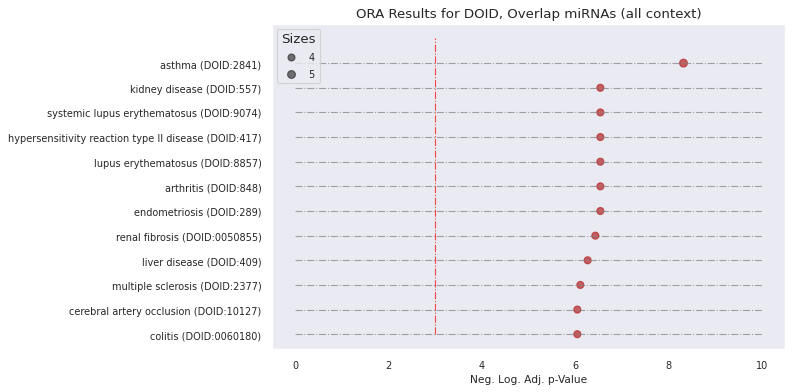

In [428]:
plotORAresult(all_disease_overlap, "ORA Results for DOID, Overlap miRNAs (all context)", numResults=12, filename="doid_all_context_overlap_mirnas.png")

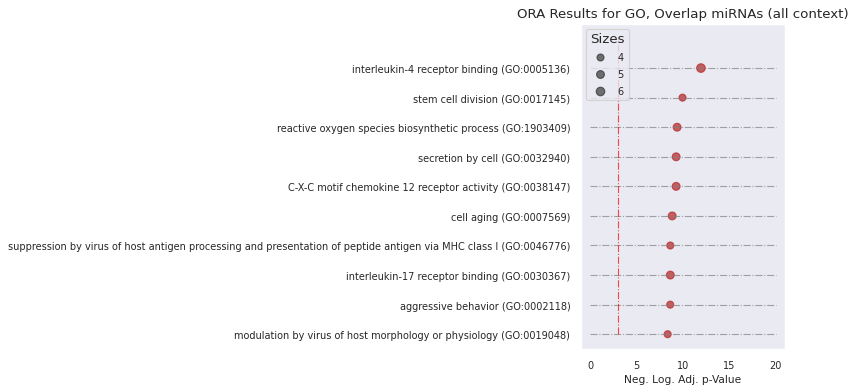

In [416]:
plotORAresult(all_go_overlap, "ORA Results for GO, Overlap miRNAs (all context)", numResults=10, filename="go_all_context_overlap_mirnas.png")

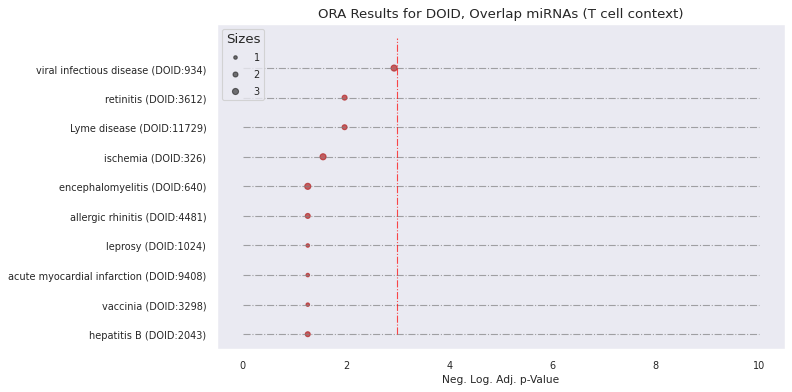

In [417]:
plotORAresult(tcell_disease_overlap, "ORA Results for DOID, Overlap miRNAs (T cell context)", numResults=10, filename="doid_tcell_context_overlap_mirnas.png")

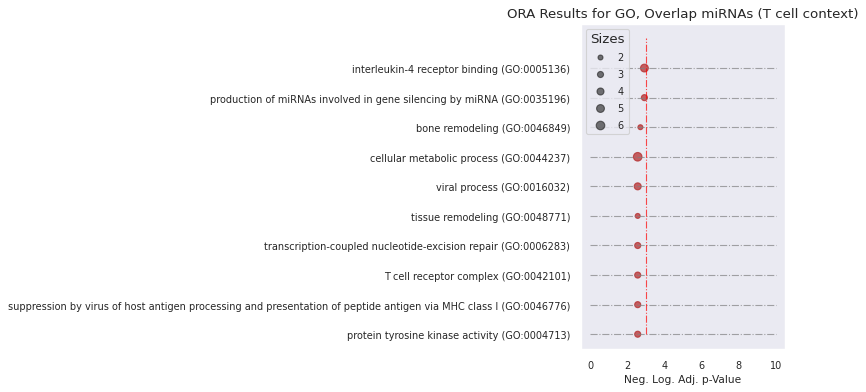

In [418]:
plotORAresult(tcell_go_overlap, "ORA Results for GO, Overlap miRNAs (T cell context)", numResults=10, filename="go_tcell_context_overlap_mirnas.png")

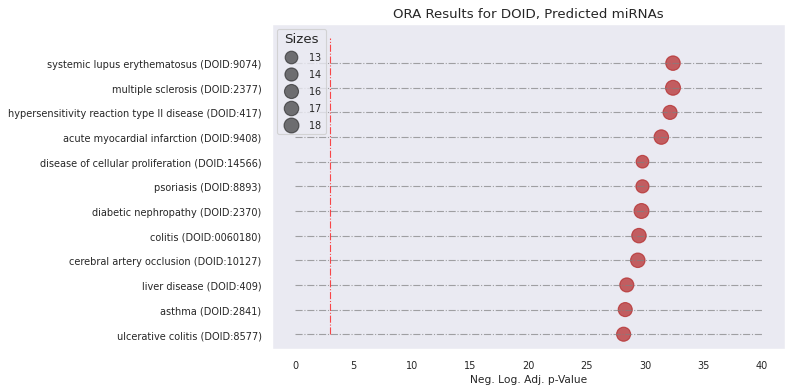

In [419]:
plotORAresult(all_disease_predicted, "ORA Results for DOID, Predicted miRNAs", numResults=12, filename="doid_all_context_predicted_mirnas.png")

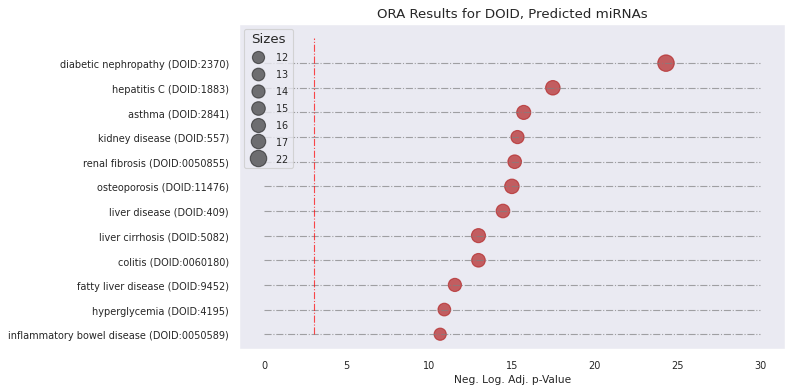

In [427]:
plotORAresult(all_disease_measured, "ORA Results for DOID, Measured miRNAs", numResults=12, filename="doid_all_context_measured_mirnas.png")

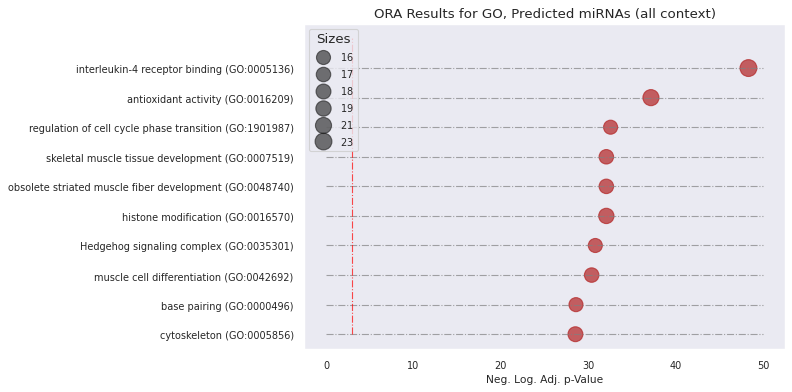

In [420]:
plotORAresult(all_go_predicted, "ORA Results for GO, Predicted miRNAs (all context)", numResults=10, filename="go_all_context_predicted_mirnas.png")

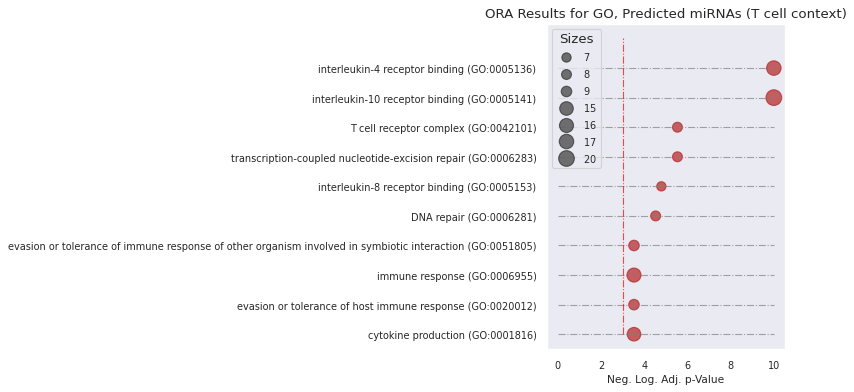

In [421]:
plotORAresult(tcell_go_predicted, "ORA Results for GO, Predicted miRNAs (T cell context)", numResults=10, filename="go_tcell_context_predicted_mirnas.png")

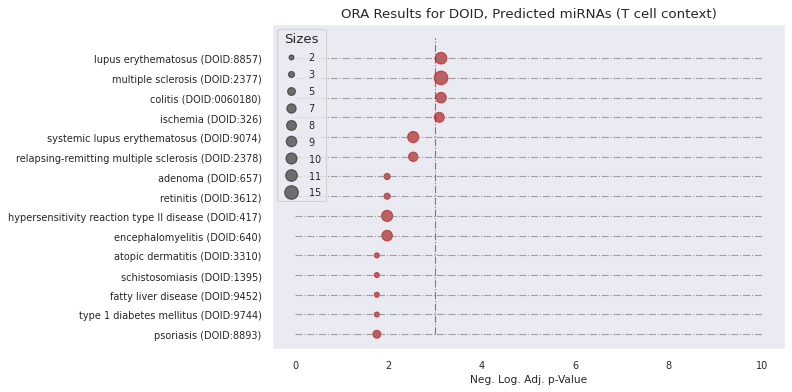

In [425]:
plotORAresult(tcell_disease_predicted, "ORA Results for DOID, Predicted miRNAs (T cell context)", numResults=15, filename="doid_tcell_context_predicted_mirnas.png")

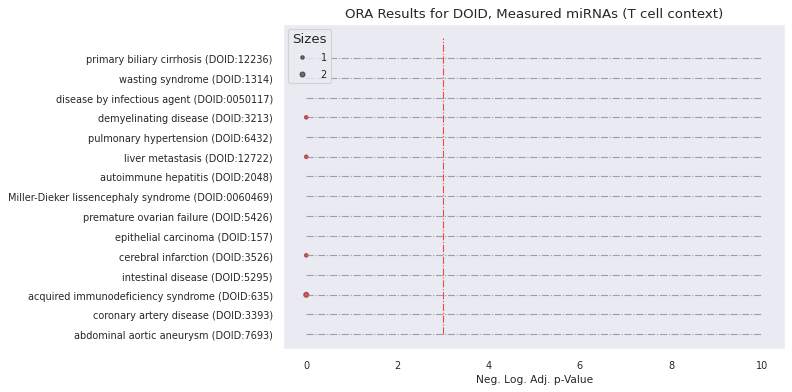

In [426]:
plotORAresult(tcell_disease_measured, "ORA Results for DOID, Measured miRNAs (T cell context)", numResults=15, filename="doid_tcell_context_measured_mirnas.png")

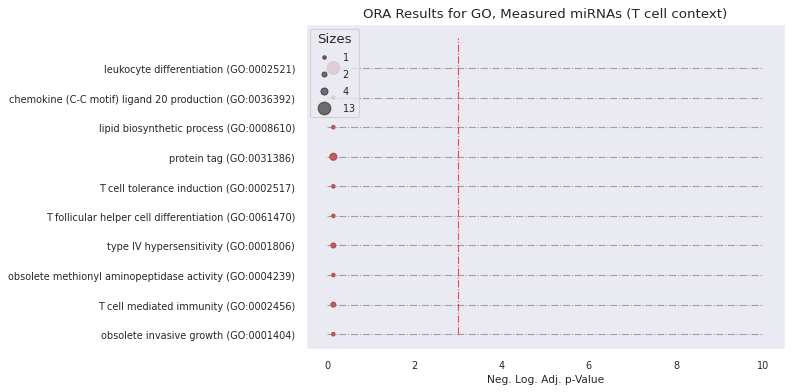

In [422]:
plotORAresult(tcell_go_measured, "ORA Results for GO, Measured miRNAs (T cell context)", numResults=10, filename="go_tcell_context_measured_mirnas.png")

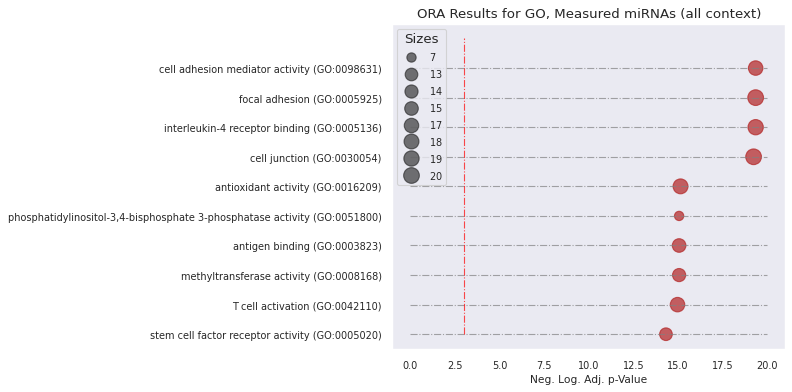

In [423]:
plotORAresult(all_go_measured, "ORA Results for GO, Measured miRNAs (all context)", numResults=10, filename="go_all_context_measured_mirnas.png")

In [481]:
from scipy.stats import kendalltau, spearmanr, pearsonr,f_oneway, rankdata

topN = 20

In [468]:
all_disease_measured_ordered = sorted([x for x in all_disease_measured], key=lambda x: all_disease_measured[x]["adj_pval"])
all_disease_measured_list = [all_disease_measured[x]["termid"] for x in all_disease_measured_ordered][:topN]

In [469]:
all_disease_overlap_ordered = sorted([x for x in all_disease_overlap], key=lambda x: all_disease_overlap[x]["adj_pval"])
all_disease_overlap_list = [all_disease_overlap[x]["termid"] for x in all_disease_overlap_ordered][:topN]

In [470]:
all_disease_predicted_ordered = sorted([x for x in all_disease_predicted], key=lambda x: all_disease_predicted[x]["adj_pval"])
all_disease_predicted_list = [all_disease_predicted[x]["termid"] for x in all_disease_predicted_ordered][:topN]

In [485]:
kendalltau(all_disease_overlap_list, all_disease_measured_list)

KendalltauResult(correlation=0.0736842105263158, pvalue=0.6771082386478993)

In [486]:
kendalltau(all_disease_overlap_list, all_disease_predicted_list)

KendalltauResult(correlation=0.2947368421052632, pvalue=0.07402572925713644)

In [488]:
kendalltau(all_disease_measured_list, all_disease_predicted_list)

KendalltauResult(correlation=-0.042105263157894736, pvalue=0.8226828854421665)

In [482]:
rankdata(all_disease_overlap_list)

array([10., 15., 11., 19., 14., 20., 17.,  1., 13.,  9.,  4.,  2., 18.,
        5., 12.,  3.,  8.,  6.,  7., 16.])

In [507]:

foundSig = set()

for setsize in range(2, min([len(all_disease_measured), len(all_disease_overlap), len(all_disease_predicted)])):
    all_disease_measured_ordered = sorted([x for x in all_disease_measured], key=lambda x: all_disease_measured[x]["adj_pval"])
    all_disease_measured_list = [all_disease_measured[x]["termid"] for x in all_disease_measured_ordered][:setsize]

    all_disease_overlap_ordered = sorted([x for x in all_disease_overlap], key=lambda x: all_disease_overlap[x]["adj_pval"])
    all_disease_overlap_list = [all_disease_overlap[x]["termid"] for x in all_disease_overlap_ordered][:setsize]

    all_disease_predicted_ordered = sorted([x for x in all_disease_predicted], key=lambda x: all_disease_predicted[x]["adj_pval"])
    all_disease_predicted_list = [all_disease_predicted[x]["termid"] for x in all_disease_predicted_ordered][:setsize]
    
    ktm = kendalltau(all_disease_overlap_list, all_disease_measured_list)
    ktp = kendalltau(all_disease_overlap_list, all_disease_predicted_list)
    

    
    if ktp.pvalue < 0.05 or ktm.pvalue < 0.05:
        
        if ktp.pvalue < 0.05 and "ktp" in foundSig:
            continue
            
        if ktm.pvalue < 0.05 and "ktm" in foundSig:
            continue
        
        print(setsize)
        print("msd", ktm)
        print("prd", ktp)
        
        if setsize < 50:
            print("msd", all_disease_measured_list)
            print("ovl", all_disease_overlap_list)
            print("prd", all_disease_predicted_list)
            print("int_prd", set(all_disease_overlap_list).intersection(all_disease_predicted_list))
            print("int_msd", set(all_disease_overlap_list).intersection(all_disease_measured_list))
    
        print()
        print()
        
        if setsize > 100:
            
            if ktp.pvalue < 0.05:
                foundSig.add("ktp")
                
            if ktm.pvalue < 0.05:
                foundSig.add("ktm")
            
        if len(foundSig) > 1:
            break
            
print(setsize)
    

5
msd KendalltauResult(correlation=0.19999999999999998, pvalue=0.8166666666666667)
prd KendalltauResult(correlation=0.9999999999999999, pvalue=0.016666666666666666)
msd ['DOID:2370', 'DOID:1883', 'DOID:2841', 'DOID:557', 'DOID:0050855']
ovl ['DOID:2841', 'DOID:557', 'DOID:289', 'DOID:8857', 'DOID:417']
prd ['DOID:2377', 'DOID:9074', 'DOID:417', 'DOID:9408', 'DOID:8893']
int_prd {'DOID:417'}
int_msd {'DOID:2841', 'DOID:557'}


603
msd KendalltauResult(correlation=0.014385437155308729, pvalue=0.5972628169926311)
prd KendalltauResult(correlation=0.05421948948502229, pvalue=0.04644296982250949)


954


In [6]:
def getPMIDInfo(jsonRes, infodict, pmid):
    
    diseaseInfos = jsonRes["pmidinfo"][infodict].get(pmid, [])
    diseaseInfo = ""
        
    infoObo = infodict2obo.get(infodict, None)
    
    ignoreTerms = None
    if infodict == "cells":
        ignoreTerms = []
        
        for ignoreTerm in ["META:3", "META:707", "EFO:0000408", "META:403", "EFO:0000408", "BFO:0000017"]:
            ignoreTerms += [x.termid for x in infoObo[ignoreTerm].getAllChildren()]

    allFoundTerms = set()
    termid2termname = {}
    allDiseaseInfos = Counter()
    for di in diseaseInfos:
        dit = di.get("termname", None)
        diid = di.get("termid", None)
        
        #print(di["termid"], dit)
        
        if dit in ["cell", "disease", "cells", "protein", "data item", "role", "signaling", "immune response"]:
            continue
            
        if infodict == "cells" and diid != None and diid.startswith(("CHEBI", "PR", "DOID", "UBERON", "IAO")):
            continue
        
        if diid != None:
            allFoundTerms.add(diid)
            termid2termname[diid] = dit
            
        
        for diid in allFoundTerms:
            
            if infoObo != None:
                oboterm = infodict2obo[infodict][diid]
                
                if oboterm != None:
                    allchildren = [x.termid for x in oboterm.getAllChildren()]
                    allparents = [x.id for x in oboterm.getAllParents()]
                    
                    childIntersect = set(allchildren).intersection(allFoundTerms)
                    parentIntersect = set(allparents).intersection(allFoundTerms)

                    if (len(parentIntersect)>0) or (ignoreTerms != None and diid in ignoreTerms):
                        
                        igTerm = ignoreTerms != None and diid in ignoreTerms
                        
                        #print("skipping", diid, termid2termname[diid], len(parentIntersect), igTerm)
                        continue
                        
                    if len(childIntersect)> 0:
                        for x in childIntersect:
                            
                            if termid2termname[x] in allDiseaseInfos:
                                del allDiseaseInfos[termid2termname[x]]
                            #print("removing", termid2termname[x])
                        
        
            dit = termid2termname[diid]
            allFoundTerms.add(diid)
            
            allDiseaseInfos[dit] += 1

    allDiseaseInfos = [x[0] for x in allDiseaseInfos.most_common(4)]
    
    diseaseInfo = ""
    xlen = 20
    for xi, x in enumerate(allDiseaseInfos):
        

        
        if len(diseaseInfo) + len(x) > xlen:
            if xi > 0:
                diseaseInfo += ";"
            
            diseaseInfo += "\n" + x
            
            xlen += 20
                        
                
        else:
            if xi > 0:
                diseaseInfo += "; "
                
            diseaseInfo += x
            
            
                
    return diseaseInfo
    


In [7]:
def make_timeline( allInteractions, title, outpath=None ):

    allInteractions = sorted(allInteractions, key=lambda x: x[1])
    
    names = []
    dates = []

    for x in allInteractions:
        pmid = x[0] + "\n" + x[2] + "\n" + x[3] + "\n" + x[4]
        date = datetime.datetime.fromtimestamp(x[1])

        names.append(pmid)
        dates.append(date)
        
    alllevels = [-5,5,-1,1] #-3,3,
        
    # Choose some nice levels
    levels = np.tile(alllevels,
                     int(np.ceil(len(dates)/len(alllevels))))[:len(dates)]
    
    szFac = len(names) // 15
    szFac += 1

    # Create figure and plot a stem plot with the date
    fig, ax = plt.subplots(figsize=(szFac * 15, 15), constrained_layout=True)
    ax.set(title=title)

    markerline, stemline, baseline = ax.stem(dates, levels,
                                             linefmt="C3-", basefmt="k-",
                                             use_line_collection=True)

    plt.setp(markerline, mec="k", mfc="w", zorder=3)

    # Shift the markers to the baseline by replacing the y-data by zeros.
    markerline.set_ydata(np.zeros(len(dates)))

    # annotate lines
    vert = np.array(['top', 'bottom'])[(levels > 0).astype(int)]
    for d, l, ltext, va in zip(dates, levels, names, vert):
        ax.annotate(ltext, xy=(d, l+ (-1) * np.sign(l) * 0.75), xytext=(-10, np.sign(l)*4),
                    textcoords="offset points", va=va, ha="right")

    # format xaxis with 4 month intervals
    ax.get_xaxis().set_major_locator(mdates.MonthLocator(interval=6))
    ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %Y"))
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

    # remove y axis and spines
    ax.get_yaxis().set_visible(False)
    for spine in ["left", "top", "right"]:
        ax.spines[spine].set_visible(False)

    ax.margins(y=0.1)
    
    if outpath != None:
        plt.savefig(outpath)
    plt.show()

In [8]:
all_pubs = set()

for x in jsonRes['rels']:
    for y in x["evidences"]:
        
        docID = y.get("docid", None)
        docDate = y.get("docdate", None)
        
        if docID == None or docDate == None:
            continue
        
        gene = y.get("lid", None)
        mirStr = y.get("rid", None)
        
        mirObj = miRNA(mirStr)
        
        diseaseInfo = getPMIDInfo(jsonRes, "disease", docID)
        cellInfo = getPMIDInfo(jsonRes, "cells", docID)
        goInfo = getPMIDInfo(jsonRes, "go", docID)
            
        
        all_pubs.add((docID, docDate, diseaseInfo, cellInfo, goInfo))
        

NameError: name 'jsonRes' is not defined

In [8]:
def generateInteractionHistory( gene, mir, context=None, outfile=None):
    
    if not gene is None:    
        requestDict = {"gene": [gene], "sentences": "false"}
    elif not mir is None:
        requestDict = {"mirna": [mir], "sentences": "false"}
        
    origGene = gene
    origMir = mir
        
    if not context is None:
        for x in context:
            requestDict[x] = context[x]

    r = requests.post("http://localhost:65500/find_interactions", data=json.dumps(requestDict))
    jsonRes = r.json()
    
    all_pubs = set()
    
    targetMir = None
    if not mir is None:
        targetMir = miRNA(mir)
        
    doc2evidences = defaultdict( lambda: defaultdict(set))

    for x in jsonRes['rels']:
        for y in x["evidences"]:

            docID = y.get("docid", None)
            docDate = y.get("docdate", None)

            if docID == None or docDate == None:
                continue

            gene = y.get("lid", None)
            mirStr = y.get("rid", None)

            mirObj = miRNA(mirStr)
            
            if not targetMir is None:
                if not targetMir.accept(mirObj, miRNACOMPARISONLEVEL.PRECURSOR):
                    continue
            
            
            relInteract = y.get("rel_interaction", "MIR_GENE")
            relCategory = y.get("rel_category", "DOWN")
            
            e1 = gene
            e2 = mirStr          

            diseaseInfo = getPMIDInfo(jsonRes, "disease", docID)
            cellInfo = getPMIDInfo(jsonRes, "cells", docID)
            goInfo = getPMIDInfo(jsonRes, "go", docID)
            
            doc2evidences[docID][(e1, e2)].add( (relInteract, relCategory) )

            all_pubs.add((docID, docDate, diseaseInfo, cellInfo, goInfo))
            
            
    all_pubs_print = set()
    
    for x in all_pubs:
        
        x = list(x)
        
        docID = x[0]
        
        if docID == "23041630":
            print(x)
        
        for gene, mirStr in sorted(doc2evidences[docID]):
                    
            allEvs = doc2evidences[docID][(gene, mirStr)]
            
            if docID == "23041630":
                print(gene, mirStr, allEvs)
                
            allInteracts = list(set([y[0] for y in allEvs]))
            allCats = list(set([y[1] for y in allEvs]))

            if len(allInteracts) != 1:
                e1 = mirStr
                e2 = gene   
                e12c = u"\u21ff"

            else:
                relInteract = allInteracts[0]

                if relInteract == "MIR_GENE":
                    e1 = mirStr
                    e2 = gene               
                else:
                    e1 = gene
                    e2 = mirStr

                relCategory = "NA"
                if len(allCats) == 1:
                    relCategory = allCats[0]

                if len(allCats)== 2 and "DOWN" in allCats and "NEU" in allCats:
                    relCategory = "NEU"            

                if relCategory in ["DOWN", "DOWN*"]:
                    e12c = u"\u22a3"
                elif relCategory in ["UP"]:
                    e12c = u"\u2191"
                elif relCategory in ["NEU"]:
                    e12c = u"\u21e5"
                elif relCategory in ["NA"]:
                    print(e1, e2,allInteracts,allCats)
                    print()
                    e12c = u"\u2974"
                    e12c = u"\u1e6a"

            xDocID = u"\n{} {} {}".format(e1, e12c, e2)
            x[0] += xDocID

        all_pubs_print.add(tuple(x))
            
    print("found results", len(all_pubs_print))
    
    if not origGene is None and not origMir is None:
        title = "{}-{} interactions".format(origGene, origMir)
        
    else:
        title="{} interactions".format(origGene if origMir is None else origMir)
    
    if len(all_pubs_print):
        make_timeline( all_pubs_print, title, outpath=outfile )
    



In [15]:
requestDict = {"gene": ["CCL2"], "sentences": "false"}

r = requests.post("http://localhost:65500/find_interactions", data=json.dumps(requestDict))
jsonRes = r.json()

In [6]:
for x in jsonRes["pmidinfo"]:
    print(x, jsonRes["pmidinfo"][x].get("31875973", None))

cells [{'docid': '31875973', 'evidences': [['31875973.2.6', 116, 123, 'protein'], ['31875973.2.6', 124, 131, 'protein']], 'termid': 'META:707', 'termname': 'protein'}, {'docid': '31875973', 'evidences': [['31875973.2.12', 107, 116, 'signaling']], 'termid': 'META:403', 'termname': 'signaling'}, {'docid': '31875973', 'evidences': [['31875973.1.1', 45, 50, 'heart'], ['31875973.2.1', 44, 49, 'heart'], ['31875973.2.2', 147, 152, 'heart']], 'termid': 'META:1353', 'termname': 'circulatory organ'}, {'docid': '31875973', 'evidences': [['31875973.1.1', 16, 27, 'Ventricular'], ['31875973.2.2', 5, 16, 'Ventricular']], 'termid': 'META:894', 'termname': 'stomach'}, {'docid': '31875973', 'evidences': [['31875973.1.1', 45, 50, 'heart'], ['31875973.2.1', 44, 49, 'heart'], ['31875973.2.2', 147, 152, 'heart']], 'termid': 'META:896', 'termname': 'heart'}, {'docid': '31875973', 'evidences': [['31875973.1.1', 45, 50, 'heart'], ['31875973.2.1', 44, 49, 'heart'], ['31875973.2.2', 147, 152, 'heart']], 'termid'

In [7]:
for x in jsonRes['rels']:
    for y in x["evidences"]:
        
        docID = y.get("docid", None)
        docDate = y.get("docdate", None)
        
        #print(y)

In [9]:
import matplotlib
matplotlib.rcParams['font.family'] = ['Hack']

findfont: Font family ['Hack'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Hack'] not found. Falling back to DejaVu Sans.


found results 6


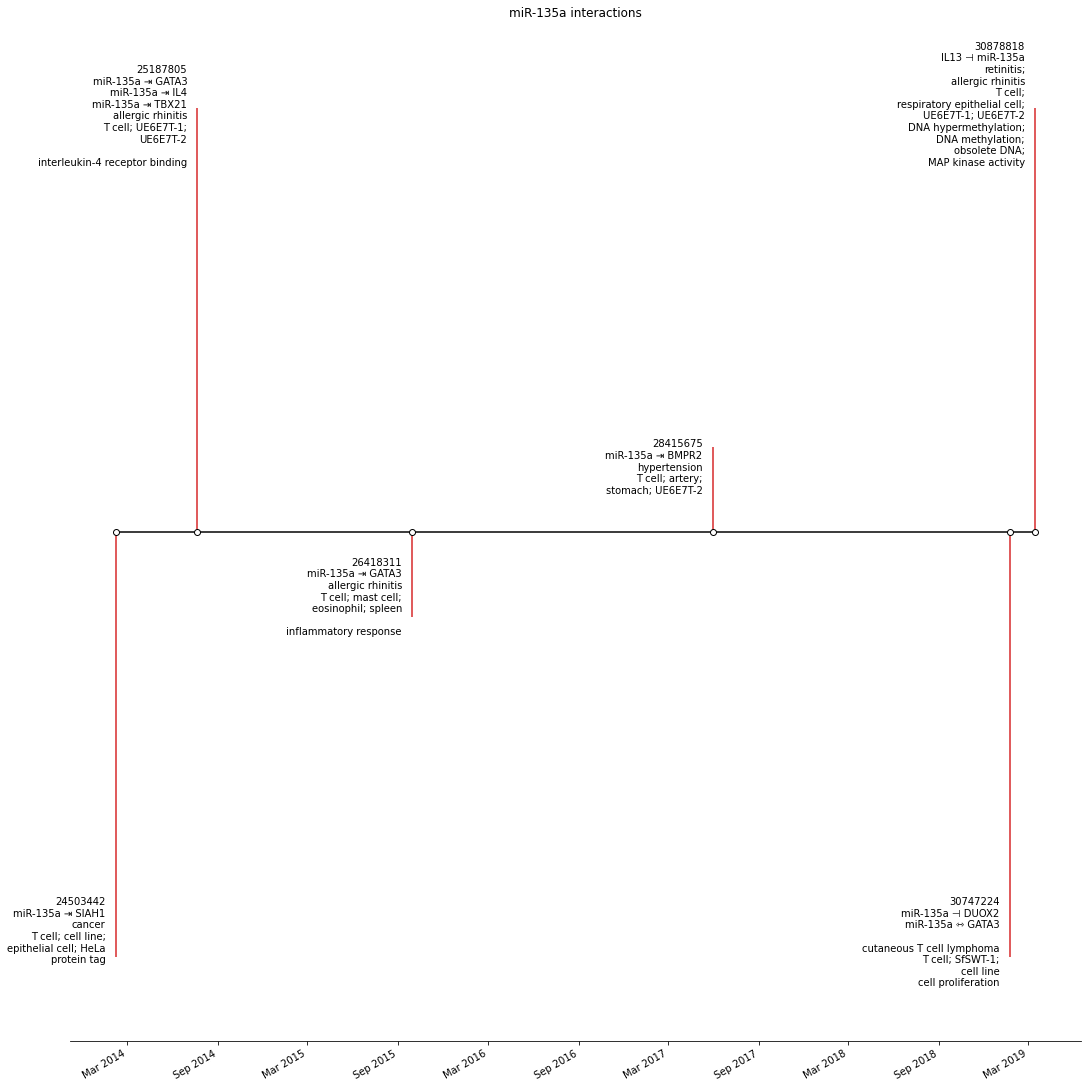

In [10]:
generateInteractionHistory(gene=None, mir="miR-135a", context={'cells': [{'termid': "META:141"}]})

found results 3


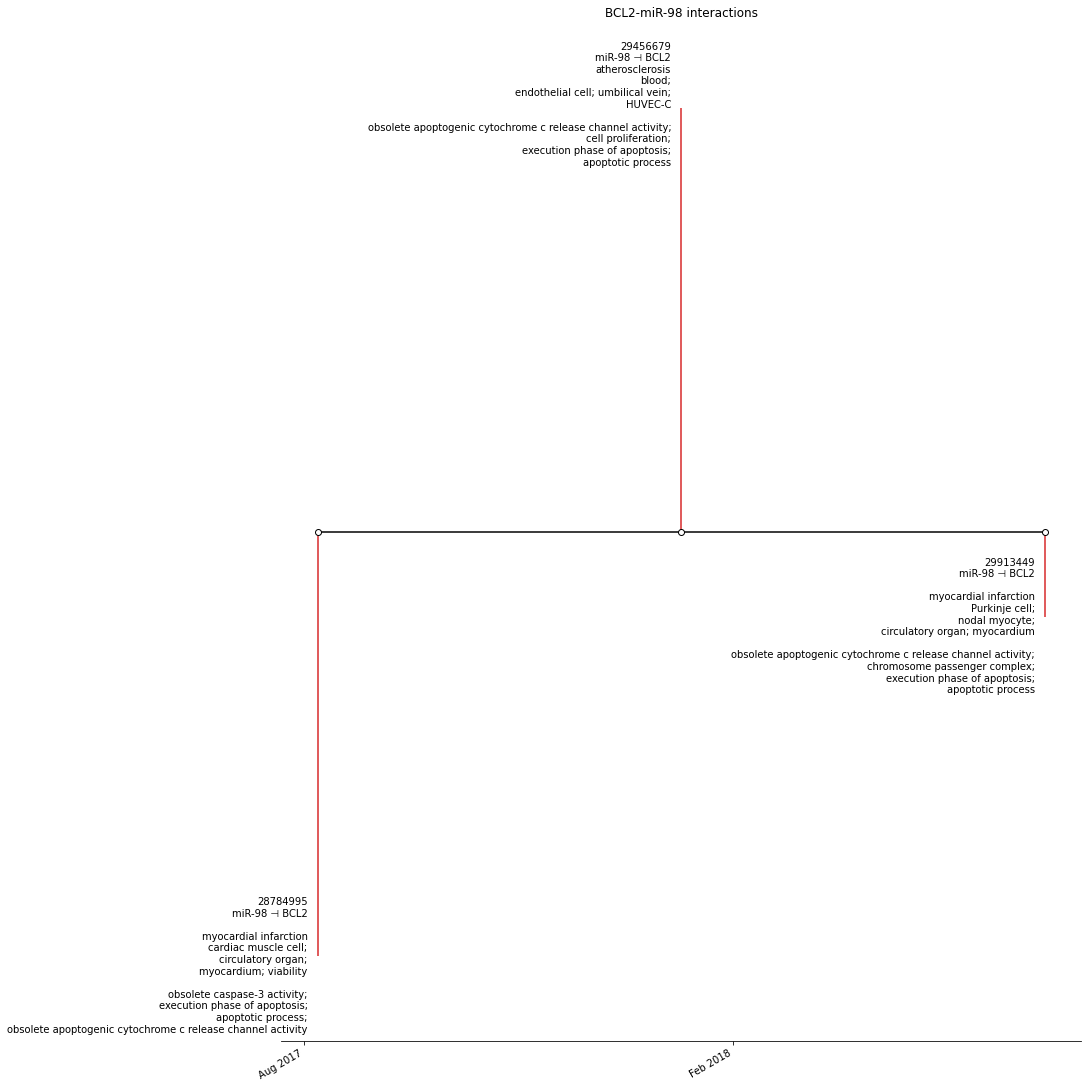

In [97]:
generateInteractionHistory(gene="BCL2", mir="miR-98", context={'disease': [{'termid': "DOID:1287"}]})

miR-155 CCL2 ['MIR_GENE'] ['UP', 'DOWN']

['23041630', 1349647200.0, 'atherosclerosis', 'leukocyte', '\nobsolete low-density lipoprotein']
CCL2 miR-155 {('MIR_GENE', 'UP'), ('MIR_GENE', 'DOWN')}
miR-155 CCL2 ['MIR_GENE'] ['UP', 'DOWN']

miR-196a CCL2 ['MIR_GENE'] ['NEU', 'UP']

miR-145 CCL2 ['MIR_GENE'] ['NEU', 'UP']

found results 29


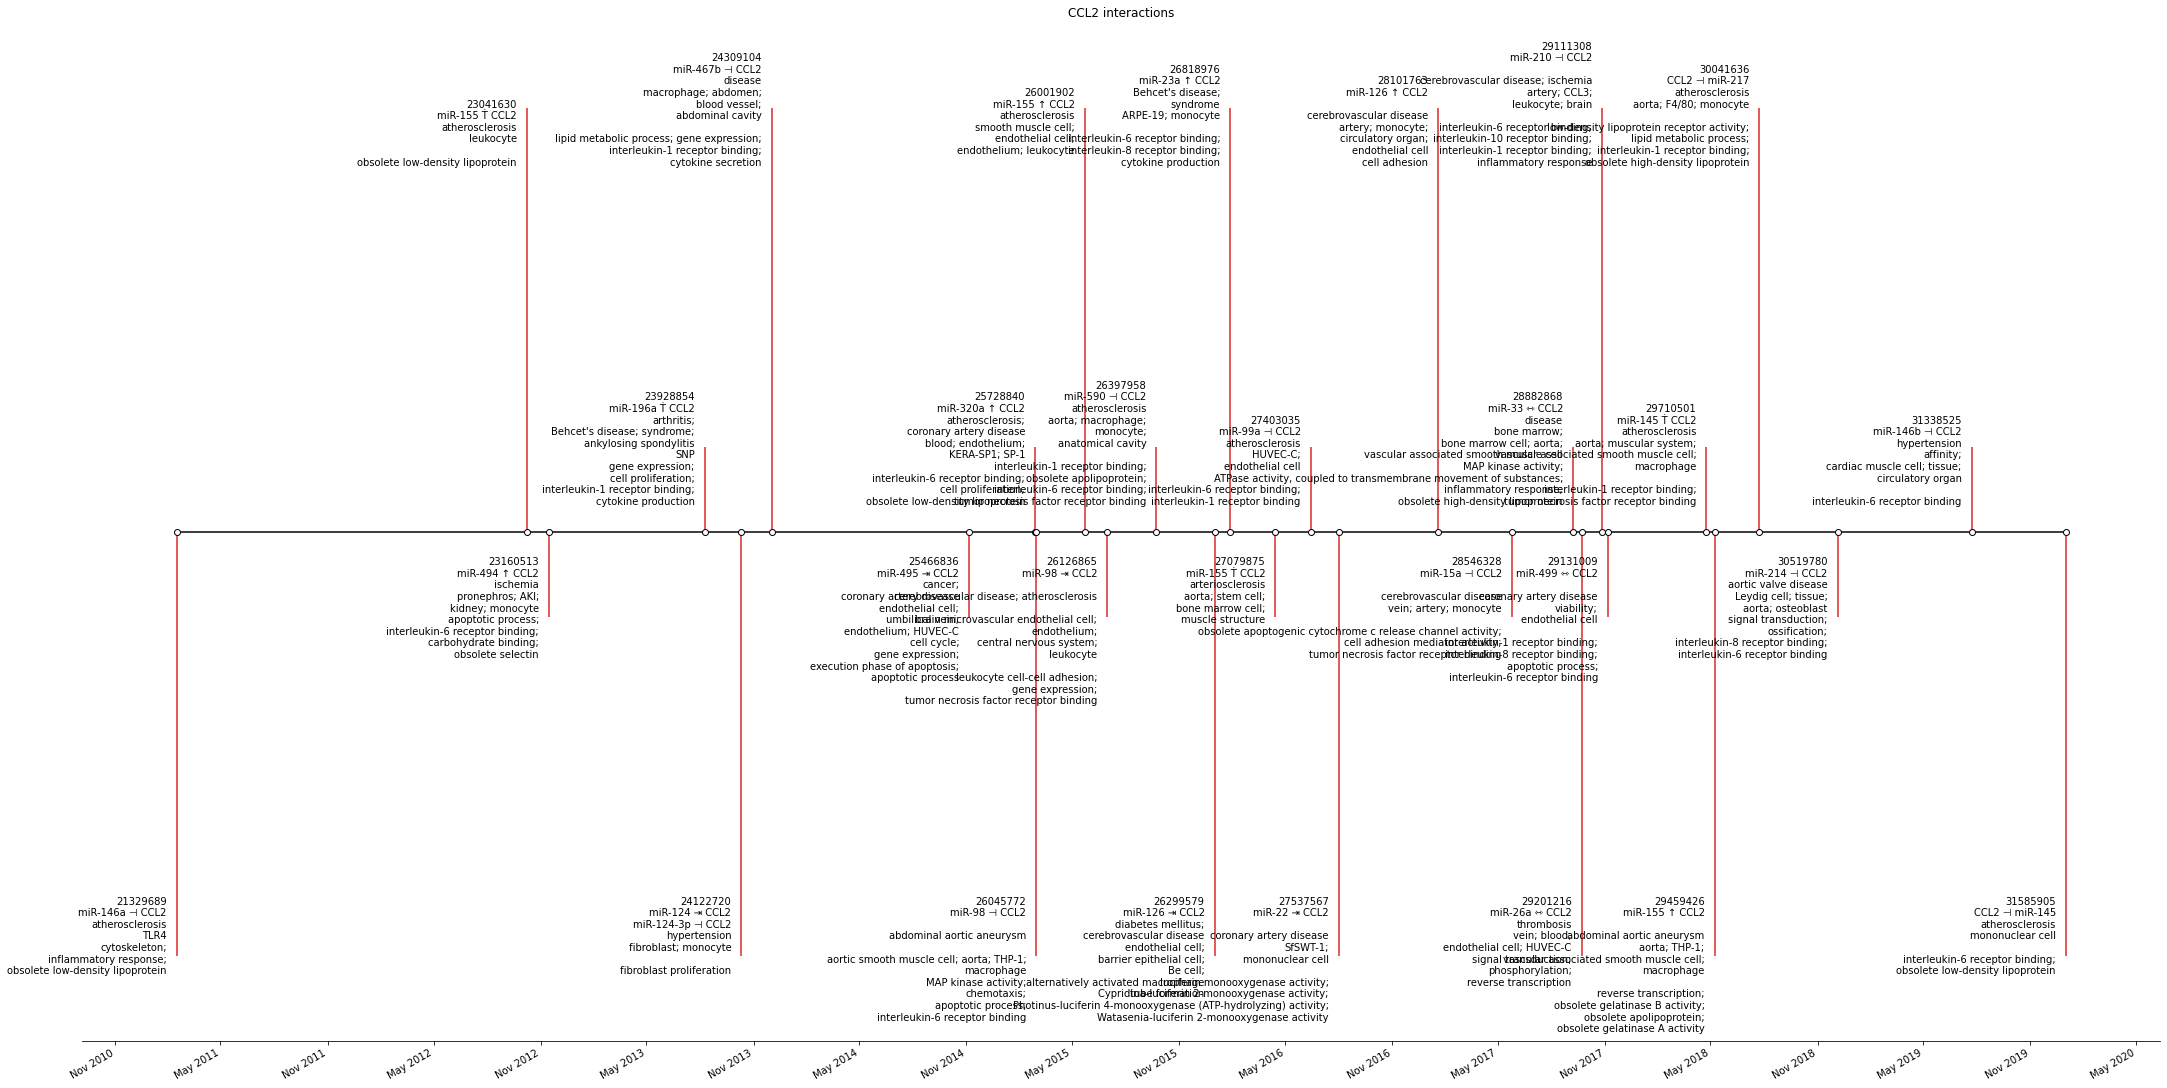

In [83]:
generateInteractionHistory(gene="CCL2", mir=None, context={'disease': [{'termid': "DOID:1287"}]})

found results 6


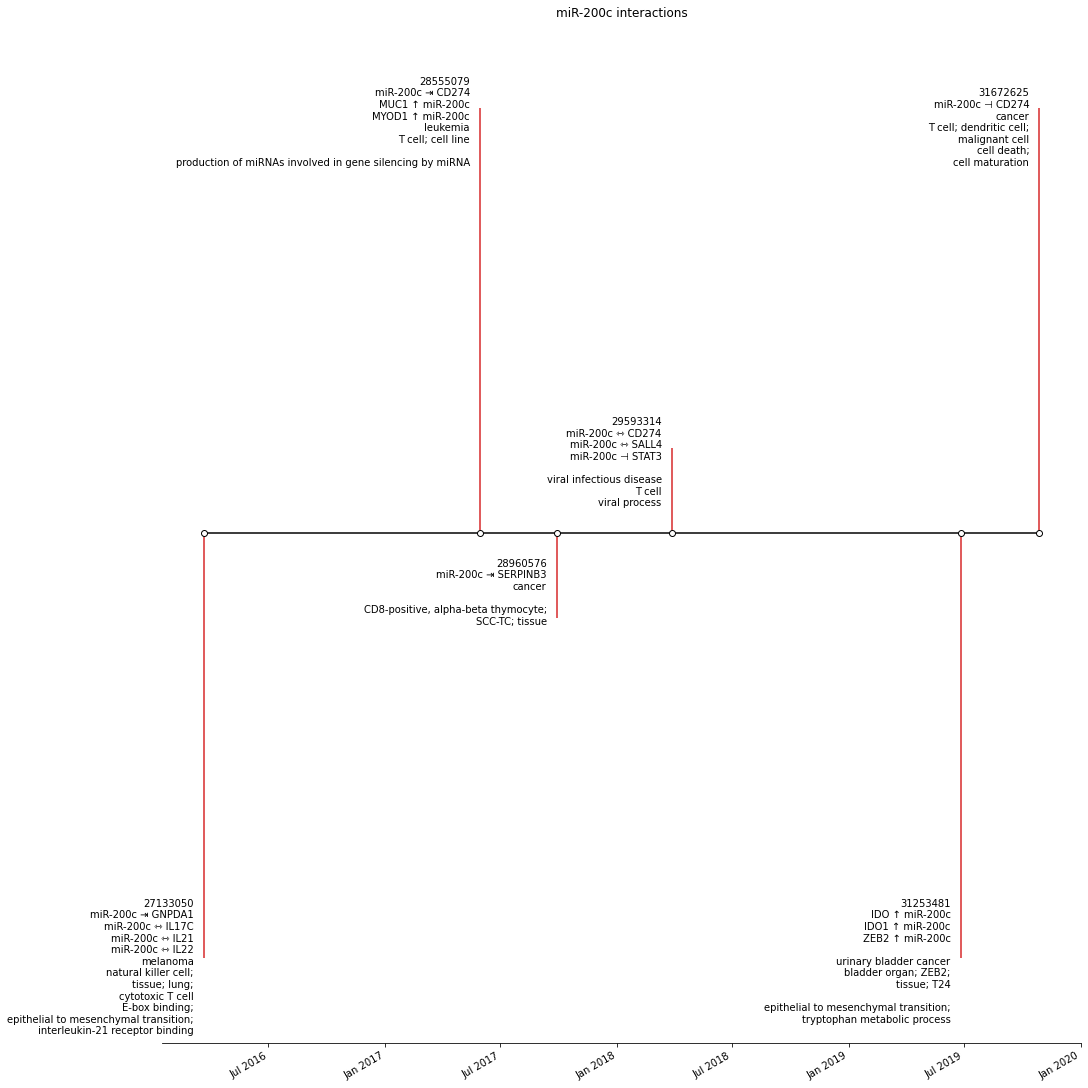

In [109]:
generateInteractionHistory(gene=None, mir="miR-200c", context={'cells': [{'termid': "META:44"}]})#context={'disease': [{'termid': "DOID:2841"}]}) 

PPARA miR-98 ['GENE_MIR'] ['NEU', 'UP', 'DOWN']

PPARD miR-98 ['GENE_MIR'] ['NEU', 'UP', 'DOWN']

PPARG miR-98 ['GENE_MIR'] ['NEU', 'UP', 'DOWN']

found results 14


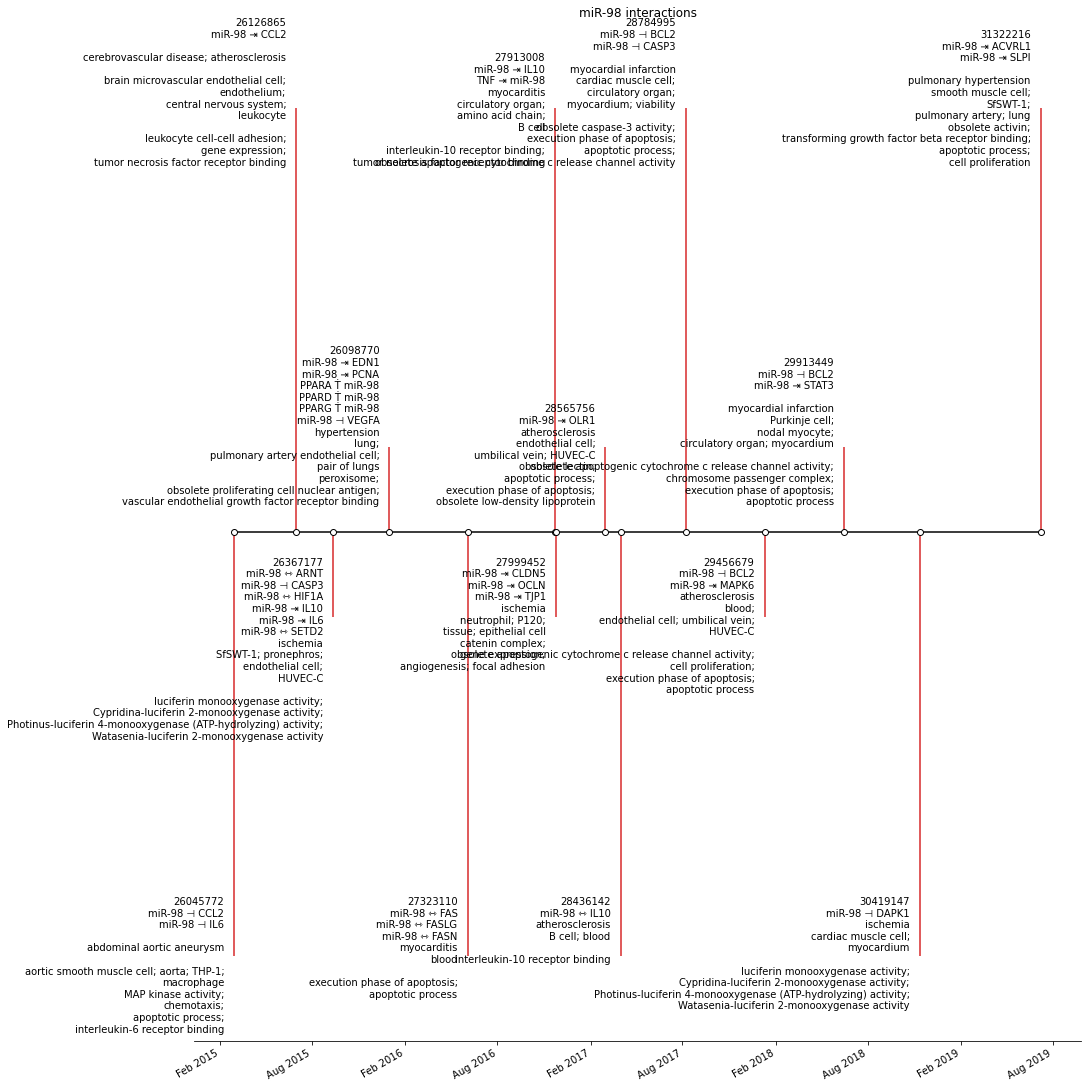

In [105]:
generateInteractionHistory(gene=None, mir="miR-98", context={'disease': [{'termid': "DOID:1287"}]}, outfile="mir98_interactions.png") 

In [ ]:
#infodict2obo["cells"]["META:5"].getAllChildren()

miR-98 E2F1 ['MIR_GENE'] ['NEU', 'UP']

PPARA miR-98 ['GENE_MIR'] ['NEU', 'UP', 'DOWN']

PPARD miR-98 ['GENE_MIR'] ['NEU', 'UP', 'DOWN']

PPARG miR-98 ['GENE_MIR'] ['NEU', 'UP', 'DOWN']

miR-98 MTDH ['MIR_GENE'] ['NEU', 'UP', 'DOWN']

miR-98 IGF1 ['MIR_GENE'] ['NEU', 'UP']

miR-98 EZH2 ['MIR_GENE'] ['NEU', 'UP', 'DOWN']

miR-98 BCL2 ['MIR_GENE'] ['UP', 'DOWN']

miR-98 IL18 ['MIR_GENE'] ['NEU', 'UP', 'DOWN']

miR-98 IL1A ['MIR_GENE'] ['NEU', 'UP', 'DOWN']

miR-98 IL1B ['MIR_GENE'] ['NEU', 'UP', 'DOWN']

miR-98 IL36A ['MIR_GENE'] ['NEU', 'UP', 'DOWN']

found results 122


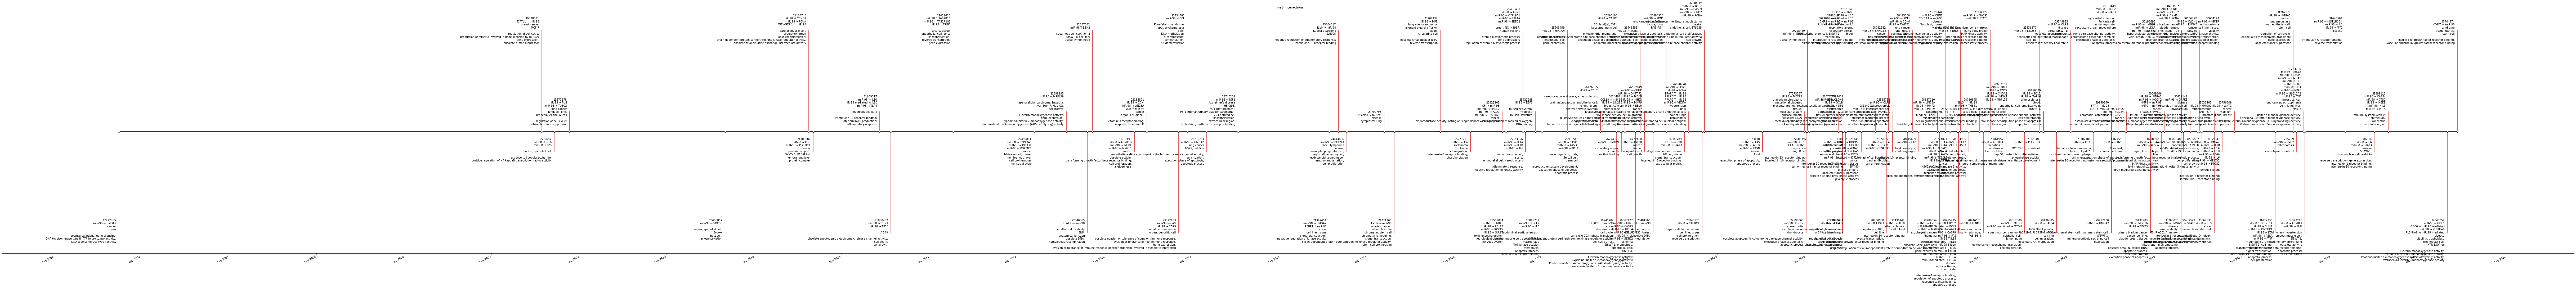

In [95]:
generateInteractionHistory(gene=None, mir="miR-98", outfile="mir98_interactions.png") 

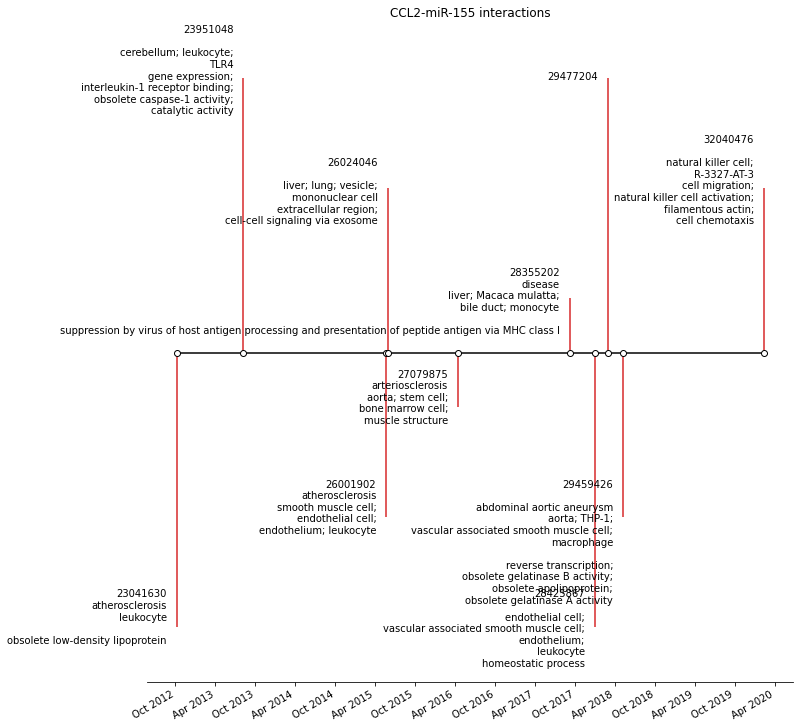

In [13]:
make_timeline(int2pubdate[('CCL2', 'miR-155')], "CCL2-miR-155 interactions", "ccl2_mir155_timeline.png") 

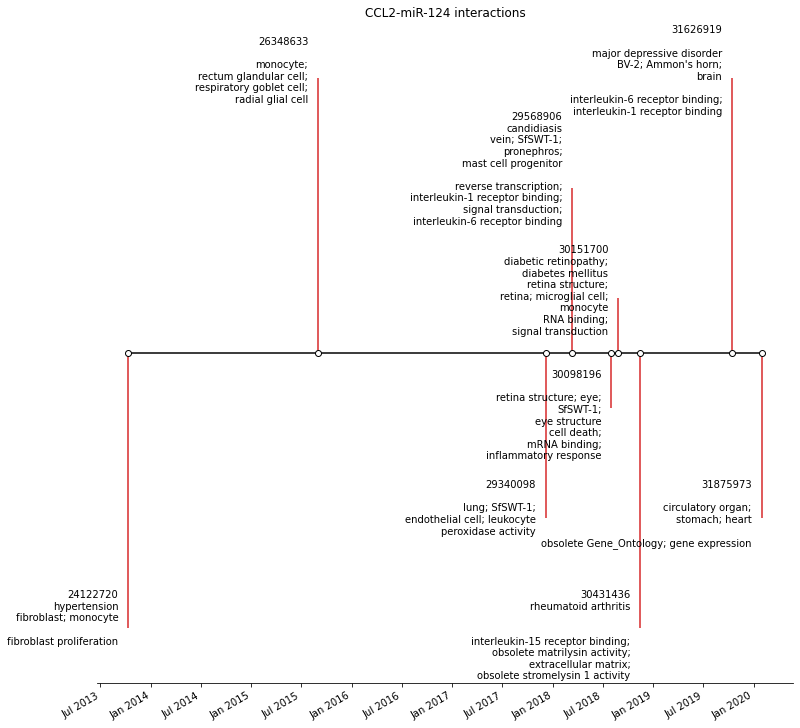

In [18]:
make_timeline(int2pubdate[('CCL2', 'miR-124')], "CCL2-miR-124 interactions", "ccl2_mir124_timeline.png") 

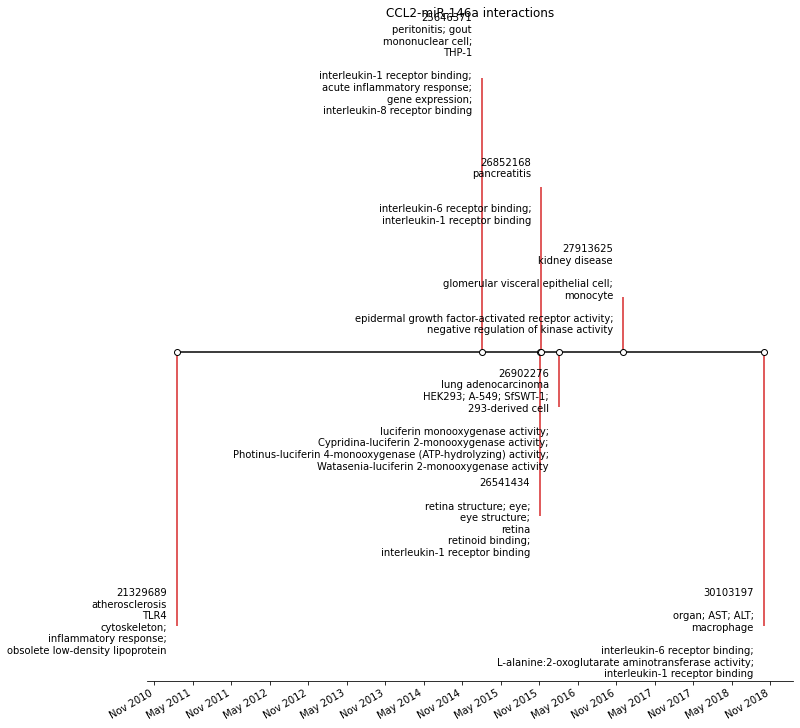

In [19]:
make_timeline(int2pubdate[('CCL2', 'miR-146a')], "CCL2-miR-146a interactions", "ccl2_mir146a_timeline.png") 

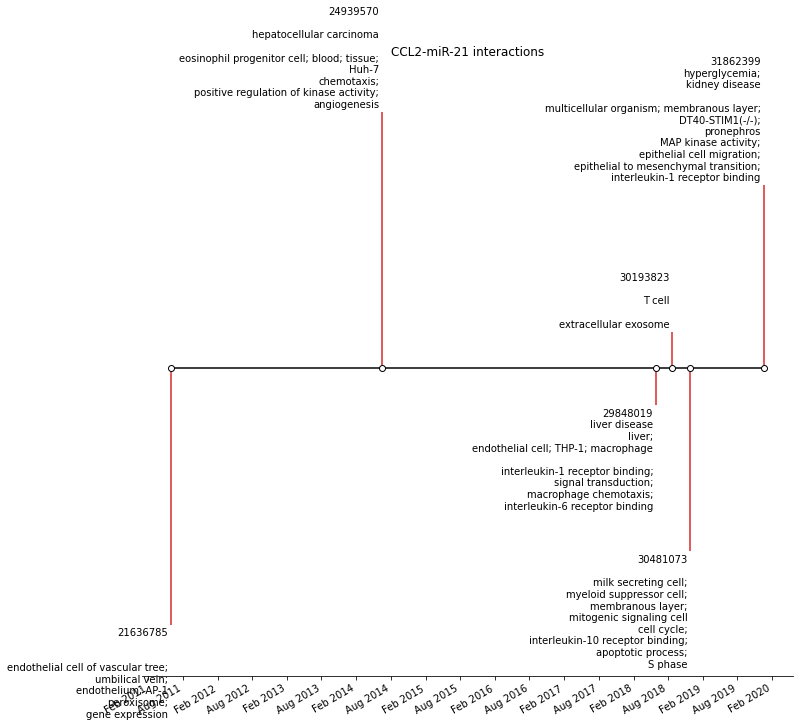

In [27]:
make_timeline(int2pubdate[('CCL2', 'miR-21')], "CCL2-miR-21 interactions") 